# Deliverable 6.1: Robust Tube MPC for Z-Dimension

Design a robust tube MPC controller for the z-subsystem to handle disturbances w ∈ [-15, 5].

In [197]:
%load_ext autoreload
%autoreload 2

# Get parent directory and add to sys.path
import sys, os
parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)

# Require ipympl
%matplotlib widget 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [198]:
from LandMPC.MPCControl_z import MPCControl_z
from src.rocket import Rocket
from src.pos_rocket_vis import *
import numpy as np

rocket_obj_path = os.path.join(parent_dir, "Cartoon_rocket.obj")
rocket_params_path = os.path.join(parent_dir, "rocket.yaml")

# Rocket setup
Ts  = 1/20
rocket = Rocket(Ts=Ts, model_params_filepath=rocket_params_path)
rocket.mass = 1.7  # Do not change!!!

# Visualization setup
vis = RocketVis(rocket, rocket_obj_path)
vis.anim_rate = 1

# Landing task: from (3, 2, 10, 30°) to (1, 0, 3, 0°)
# Linearize around target landing point
x_ref = np.array([0.]*9 + [1., 0., 3.])  # Target: x=1, y=0, z=3
xs, us = rocket.trim(x_ref)
print("Linearization around landing target:")
print("x_ref = ", x_ref)
print("xs = ", xs)
print("us = ", us)

A, B = rocket.linearize(xs, us)

# MPC parameters
sim_time = 20  # simulation length in seconds
H = 2.5  # horizon time

# Initial state: at (3, 2, 10, 30°)
x0 = np.array([0, 0, 0,  # angular velocities
               0, 0, np.deg2rad(30),  # angles (alpha, beta, gamma/roll)
               0, 0, 0,  # linear velocities
               3, 2, 10])  # positions (x, y, z)

# Create robust tube MPC controller for z-dimension
mpc = MPCControl_z(A, B, xs, us, Ts, H)
print("Robust Tube MPC initialized")
print(f"Ancillary controller K: {mpc.K}")

Linearization around landing target:
x_ref =  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 3.]
xs =  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 3.]
us =  [ 0.          0.         56.66666667  0.        ]
Minimal robust invariant set computation converged after 38 iterations.
Iteration 1... not yet converged
Iteration 2... not yet converged
Iteration 3... not yet converged
Iteration 4... not yet converged
Iteration 5... not yet converged
Iteration 6... not yet converged
Iteration 7... not yet converged
Iteration 8... not yet converged
Iteration 9... not yet converged
Iteration 10... not yet converged
Iteration 11... not yet converged
Iteration 12... not yet converged
Iteration 13... not yet converged
Iteration 14... not yet converged
Iteration 15... not yet converged
Iteration 16... not yet converged
Maximum invariant set successfully computed after 17 iterations.
Pure Tube MPC setup complete
Robust Tube MPC initialized
Ancillary controller K: [[-33.82075074 -60.01469133]]


[[ 0.31079382]
 [-6.747401  ]]


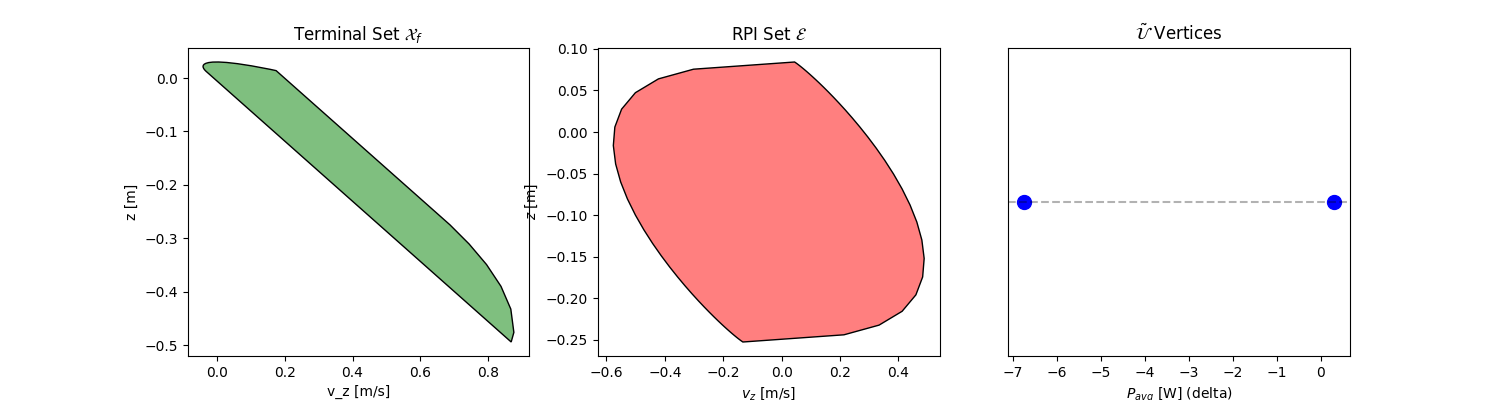

In [203]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot Xf
mpc.Xf.plot(ax=axes[0], color='g', opacity=0.5, show_vertices=False)
axes[0].set_title(r"Terminal Set $\mathcal{X}_f$")
axes[0].set_xlabel(r"v_z [m/s]")
axes[0].set_ylabel(r"z [m]")
axes[0].set_aspect("auto")

# Plot E
mpc.E.plot(ax=axes[1], color='r', opacity=0.5, show_vertices=False)
axes[1].set_title(r"RPI Set $\mathcal{E}$")
axes[1].set_xlabel(r"$v_z$ [m/s]")
axes[1].set_ylabel(r"$z$ [m]")
axes[1].set_aspect("auto")

# Plot U_tilde vertices (1D input space)
if hasattr(mpc.U_tilde, 'V') and mpc.U_tilde.V is not None:
    vertices = mpc.U_tilde.V
    axes[2].scatter(vertices, [0]*len(vertices), s=100, c='b', marker='o')
    axes[2].axhline(y=0, color='k', linestyle='--', alpha=0.3)
    axes[2].set_title(r"$\tilde{\mathcal{U}}$ Vertices")
    axes[2].set_xlabel(r"$P_{avg}$ [W] (delta)")
    axes[2].set_yticks([])
else:
    # Fallback: show as interval using bounds
    axes[2].axvspan(mpc.U_tilde.b[1], -mpc.U_tilde.b[0], alpha=0.3, color='b')
    axes[2].set_title(r"$\tilde{\mathcal{U}}$")
    axes[2].set_xlabel(r"$P_{avg}$ [W] (delta)")
    axes[2].set_yticks([])
print(mpc.U_tilde.V)
# plt.tight_layout()
plt.show()

## Test 1: Simulation with No Noise

AppLayout(children=(HBox(children=(Play(value=0, description='Press play', max=399, step=2), IntSlider(value=0…

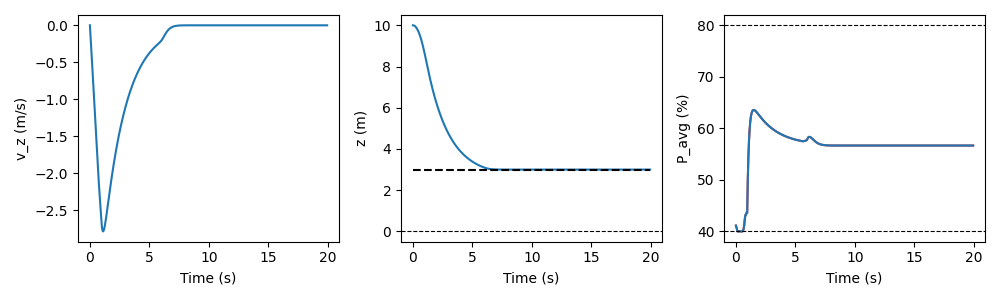

In [200]:
t_cl, x_cl, u_cl = rocket.simulate_subsystem(mpc, sim_time, x0, w_type='no_noise')
vis.animate(t_cl[:-1], x_cl[:,:-1], u_cl)
plot_static_states_inputs(t_cl[:-1], x_cl[:,:-1], u_cl, xs, 'sys_z')

## Test 2: Simulation with Random Noise

AppLayout(children=(HBox(children=(Play(value=0, description='Press play', max=399, step=2), IntSlider(value=0…

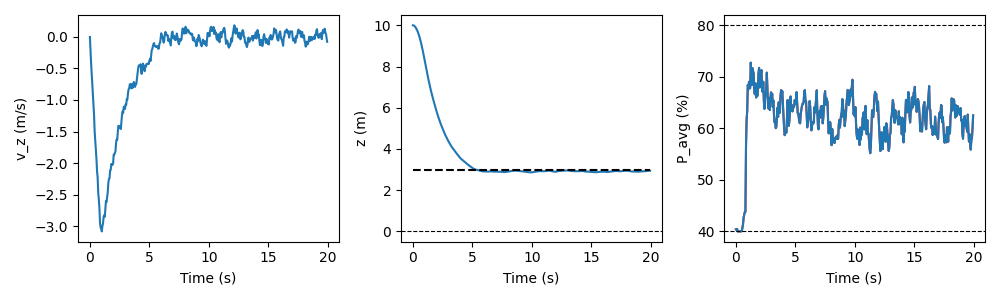

In [201]:
t_cl, x_cl, u_cl = rocket.simulate_subsystem(mpc, sim_time, x0, w_type='random')
vis.animate(t_cl[:-1], x_cl[:,:-1], u_cl)
plot_static_states_inputs(t_cl[:-1], x_cl[:,:-1], u_cl, xs, 'sys_z')

## Test 3: Simulation with Extreme Disturbance

AppLayout(children=(HBox(children=(Play(value=0, description='Press play', max=399, step=2), IntSlider(value=0…

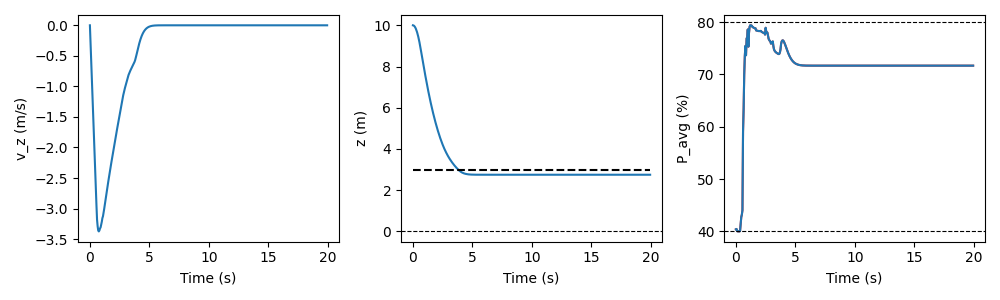

In [202]:
t_cl, x_cl, u_cl = rocket.simulate_subsystem(mpc, sim_time, x0, w_type='extreme')
vis.animate(t_cl[:-1], x_cl[:,:-1], u_cl)
plot_static_states_inputs(t_cl[:-1], x_cl[:,:-1], u_cl, xs, 'sys_z')